In [1]:
from fastai.vision import *
from fastai import *
from fastai.callbacks import *
from fastai.vision.models.unet import _get_sfs_idxs, model_sizes, hook_outputs

In [2]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/pascal_2007/train.json'),
 PosixPath('/home/jupyter/.fastai/data/pascal_2007/valid.json'),
 PosixPath('/home/jupyter/.fastai/data/pascal_2007/test.json'),
 PosixPath('/home/jupyter/.fastai/data/pascal_2007/test'),
 PosixPath('/home/jupyter/.fastai/data/pascal_2007/train')]

In [3]:
train_images, train_lbl_bbox = get_annotations(path/'train.json')
val_images, val_lbl_bbox = get_annotations(path/'valid.json')
images, lbl_bbox = train_images+val_images,train_lbl_bbox+val_lbl_bbox
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [6]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'train')
    src = src.split_by_files(val_images)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True,resize_method=ResizeMethod.SQUISH)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate,num_workers=8).normalize(imagenet_stats)

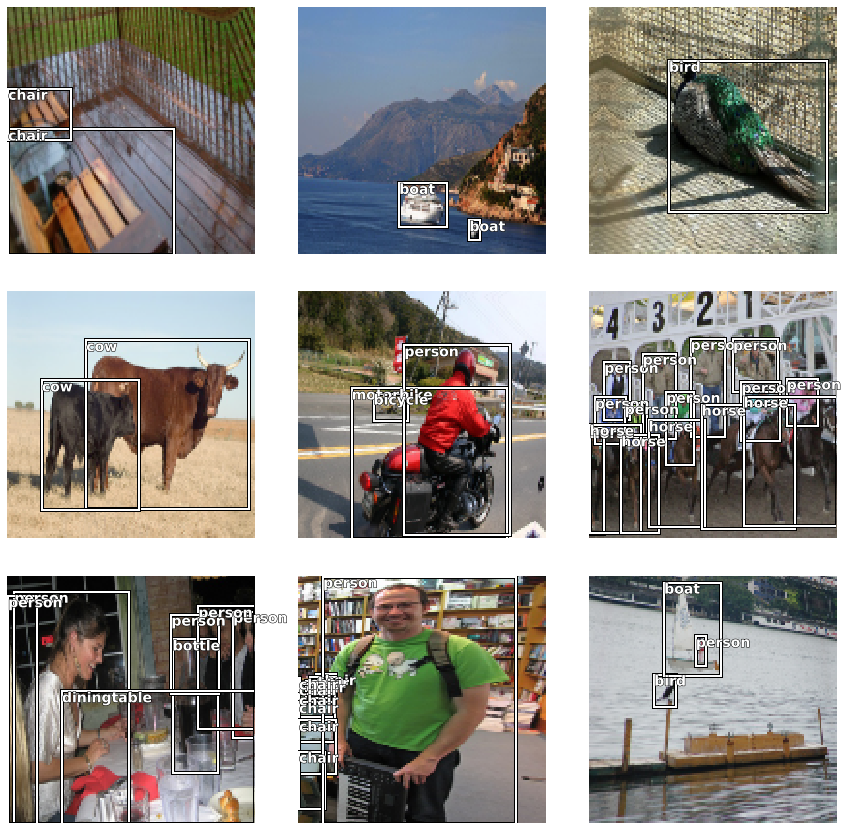

In [7]:
data = get_data(64,128)
data.show_batch(rows=3)

In [8]:
encoder = create_body(models.resnet50,cut=-2)
sfs_szs = model_sizes(encoder,size=(128,128))
sfs_szs

[torch.Size([1, 64, 64, 64]),
 torch.Size([1, 64, 64, 64]),
 torch.Size([1, 64, 64, 64]),
 torch.Size([1, 64, 32, 32]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 512, 16, 16]),
 torch.Size([1, 1024, 8, 8]),
 torch.Size([1, 2048, 4, 4])]

In [9]:
sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
sfs_idxs

[6, 5, 4, 2]

In [12]:
#Helper function
def un_pad(boxes,labels):
    bb_keep = ((boxes[:,2] - boxes[:,0])>0).nonzero()[:,0]
    return boxes[bb_keep],labels[bb_keep]

def box_area(boxes):
    return (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])

def intersect(box_a,box_b):
    #make sure box_a and box_b exists, otherwise undefine behavior if you call the func
    top_left = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    bot_right = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp((bot_right - top_left),min=0)
    return inter[:,:,0] * inter[:,:,1]

def iou(bbox,anchor):
    #bbox is gt_bb, anchor is anchor box, all in fastai style
    if len(bbox.shape) == 1: bbox = bbox[None,...]
    inter = intersect(bbox,anchor)
    union = box_area(bbox).unsqueeze(dim=1) + box_area(anchor).unsqueeze(dim=0) - inter #to broadcast shape to (N,16),where N is number of gt_bb for single image
    return inter / union

def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid(True, which='both')
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))
        
def create_anchor_box(size):
    H,W = size if is_tuple(size) else (size,size)
    anchors_center = create_grid((H,W))
    anchors_size = tensor([[2 / H, 2 / W] for i in range(H * W)])
    return torch.cat([anchors_center,anchors_size],dim=1)

#convert box to fastai style top left bot right anchor box
def cthw2corners(boxes):
    top = (boxes[:,0] - boxes[:,2]/2).view(-1,1)
    left = (boxes[:,1] - boxes[:,3]/2).view(-1,1)
    bot = (boxes[:,0] + boxes[:,2]/2).view(-1,1)
    right = (boxes[:,1] + boxes[:,3]/2).view(-1,1)
    return torch.cat([top,left,bot,right],dim=1)

#anchor (center,h,w)
#fastai y (top left bot right)
#convert activation to fastai y style
#assume activation is (center,h,w)
def act_to_bbox(activation,anchor):
    activation = torch.tanh(activation) #force scale to be -1,1
    act_center = anchor[:,:2] + (activation[:,:2]/2 * grid_sizes.float().to(activation.device))
    act_hw = anchor[:,2:] * (activation[:,2:]/2 + 1)
    return cthw2corners(torch.cat([act_center,act_hw],dim=1))

def map_to_gt(overlaps):
    prior_overlap,prior_idx = overlaps.max(dim=1)
    sec_overlap,sec_idx = overlaps.max(dim=0)
    sec_overlap[prior_idx] = 4.99
    for i,o in enumerate(prior_idx): 
        sec_idx[o] = i
    return sec_overlap,sec_idx

In [13]:
anc_grids = [16,8,4,2,1]
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms 
                                    for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [2/(o*2) for o in anc_grids] #2 is the h,w in fastai 1.0 (-1,1)
anc_x = np.concatenate([np.repeat(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes = np.concatenate([np.array([[2*o/ag,2*p/ag] 
              for i in range(ag*ag) for o,p in anchor_scales])
                 for ag in anc_grids]) #2/grid * scale,2 is the h,w in fastai 1.0
grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
              for i in range(ag*ag) for o,p in anchor_scales])
                  for ag in anc_grids])).unsqueeze(1) *2 #again fastai 1.0 h,w is 2
anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()
anchors.shape

torch.Size([3069, 4])

In [10]:
class Retina_Net_multi_head(nn.Module):
    def __init__(self,encoder,n_classes,img_size=256,final_bias=0.,chs=256,n_anchors=9,flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        sfs_szs = model_sizes(encoder,size=(img_size,img_size)) #grab each layer of outputs
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs))) #[6,5,4,2] = [C4,C3,C2,C1]
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs]) # hook of output [C4,C3,C2,C1]
        self.encoder = encoder #backbone
        
        self.c5top5 = conv2d(sfs_szs[-1][1],chs,ks=1,bias=True)
        self.c5top6 = conv2d(sfs_szs[-1][1],chs,ks=3,stride=2,bias=True)
        self.p6top7 = nn.Sequential(relu(),conv2d(chs,chs,ks=3,stride=2,bias=True))
        
        #TODO: P3P4,smoother
        self.latc4 = conv2d(sfs_szs[-2][1],chs,ks=1,bias=True)
        self.latc3 = conv2d(sfs_szs[-3][1],chs,ks=1,bias=True)
        self.smoother = None # to remove upsample artifact
        
        self.classifier = self._head(n_classes,n_anchors,final_bias,chs=chs)
        self.box_regressor = self._head(4,n_anchors,final_bias,chs=chs)
        
    def _head(self,n_chs,n_anchors,final_bias=0.,chs=256):
        layers = [conv_layer(chs,chs,norm_type=None,bias=True) for _ in range(4)]
        layers = layers + [conv2d(chs,n_chs * n_anchors,bias=True)]
        #use kaiming init first, or adjust the last layer weights accordingly
        #layers[-1].bias.data.zero_().add_(final_bias)
        #layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)
    
    def _flatten(self,x,n_classes):
        bs,ch,h,w = x.shape
        x = x.permute(0,2,3,1).contiguous()
        return x.view(bs,-1,n_classes)
        
        
    def forward(self,xb):
        c5 = self.encoder(xb)
        p_states = [self.c5top5(c5.clone()),self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[1]))
        
        #TODO P3P4,P6P7
        c4 = self.sfs[0].stored
        #print(c4.shape[-2:])
        p4 = self.latc4(c4) + F.interpolate(p_states[0],c4.shape[-2:],mode='nearest')
        p_states = [p4] + p_states
        c3 = self.sfs[1].stored
        p3 = self.latc3(c3) + F.interpolate(p_states[0],c3.shape[-2:],mode='nearest')
        p_states = [p3] + p_states
        
        cls, box = [],[]
        for p in p_states:
            cls_p = self.classifier(p)
            cls.append(self._flatten(cls_p,self.n_classes))
            box_p = self.box_regressor(p)
            box.append(self._flatten(box_p,4))
        return [torch.cat(box,dim=1),torch.cat(cls,dim=1)]
        
    
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [14]:
def get_weight(x,t):
    x,t = x.cpu(),t.cpu()
    alpha,gamma = 0.25,2
    p = x.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)
    
def bceloss(pred,target,num_classes,focal_loss=False):
    #print(target.shape)
    t = torch.eye(num_classes)[target.detach().cpu()][:,1:]
    p = pred[:,1:]
    #print(t.shape,p.shape)
    w = get_weight(p,t) if focal_loss else None
    return F.binary_cross_entropy_with_logits(p.cpu(),t,weight=w.detach(),reduction='sum') / (num_classes-1)

def singleSSDLoss(pbox,plabel,box,label):
    #handle ground truth object, from any shape to feature map size
    anchor_box = anchors
    base_box = cthw2corners(anchor_box) #iou take both inputs in fastai style
    bbox,clas = un_pad(box,label) #y from databunch already in fastai style
    overlaps = iou(bbox,base_box.cuda())
    try:
        gt_overlaps,gt_idx = map_to_gt(overlaps)
    except:
        return 0,0
    #map gt_idx back to classes for multi label classfication
    gt_clas = clas[gt_idx]
    pos = gt_overlaps > 0.4
    gt_clas[1-pos] = len(data.classes)
    gt_label = [o.item() if o < len(data.classes) else 0 for o in gt_clas.detach()] #vector of size of # of bbox
    pos_idx = torch.nonzero(pos)[:,0] #for which cells that gt bbox exists
    gt_bbox = bbox[gt_idx]
    
    #map pred bounding box to anchor, final box = pred box + anchor box
    p_final_box = act_to_bbox(pbox,anchor_box.cuda()) #grid size over # of anchor box along single axis
    
    
    #cal loss
    #L1loss
    loc_loss = ((p_final_box[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    #Multi classification
    label_loss = bceloss(plabel,tensor(gt_label),data.c,focal_loss=True)
    return loc_loss,label_loss

def SSD_loss(preds,*targets,print_it=False):
    batch_loc_loss,batch_label_loss = 0., 0.
    for p_box,p_label,box,label in zip(*preds,*targets):
        loc_loss,label_loss = singleSSDLoss(p_box,p_label,box,label)
        batch_loc_loss = batch_loc_loss + loc_loss
        batch_label_loss = batch_label_loss + label_loss
    total_loss = batch_loc_loss + batch_label_loss.cuda()
    if print_it: print(batch_loc_loss,batch_label_loss)
    return total_loss

In [15]:
loss_func = SSD_loss
model = Retina_Net_multi_head(encoder,data.c,img_size=128)

In [16]:
learn = Learner(data,model.cuda(),loss_func=loss_func)

In [17]:
learn.split(lambda m: (m.encoder[6],m.c5top5));

In [18]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-04
Min loss divided by 10: 2.75E-03


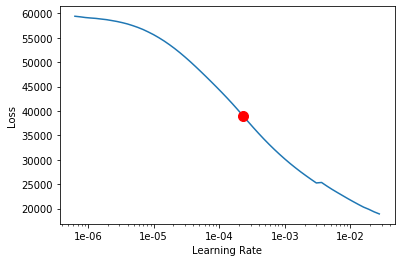

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [20]:
lr = 2e-3
learn.fit_one_cycle(6,slice(lr))

epoch,train_loss,valid_loss,time
0,4622.233398,108.156471,08:40
1,1482.769897,41.888515,08:38
2,613.556824,35.431007,08:37
3,283.387482,31.909910,08:35
4,143.840729,31.852396,08:32
5,82.173798,31.416851,08:29


In [21]:
learn.save('retina-stage-1-128')

In [22]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 5.25E-06


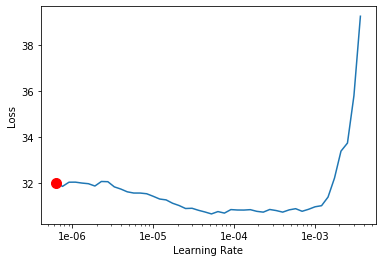

In [23]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [26]:
learn.fit_one_cycle(10,slice(5e-6,lr/5),pct_start=0.4)

epoch,train_loss,valid_loss,time
0,31.103024,31.441647,08:31
1,30.362282,29.926031,08:30
2,29.366394,27.722946,08:29
3,28.127235,27.405155,08:34
4,26.787010,25.747036,08:35
5,25.447723,24.113817,08:29
6,24.177441,23.108366,08:30
7,23.023453,22.936262,08:24
8,22.134260,22.848543,08:27
9,21.390690,22.466084,08:29


In [27]:
learn.save('retina-stage-2-128')

In [28]:
learn.model.eval();

In [29]:
xb,yb = next(iter(learn.data.valid_dl))
xb.shape

torch.Size([64, 3, 128, 128])

In [30]:
preds = learn.model(xb)
preds[0].shape,preds[1].shape

(torch.Size([64, 3069, 4]), torch.Size([64, 3069, 21]))

In [31]:
idx = 0
t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
t_bbox,t_clas

(tensor([[-0.7547, -0.2360,  1.0000,  0.8840],
         [-0.2693, -0.4920,  0.4507, -0.2200]], device='cuda:0'),
 tensor([15, 15], device='cuda:0'))

In [32]:
p_cls_test = preds[1][idx][:,1:].max(dim=1)
p_cls_test

(tensor([-4.4759, -4.6717, -4.7043,  ..., -0.6501, -0.1113, -0.3328],
        device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([14,  4, 14,  ..., 14, 14, 14], device='cuda:0'))

In [36]:
idx_clas = p_cls_test[0].sigmoid() > 0.25
idx_clas

tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0', dtype=torch.uint8)

In [37]:
p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()

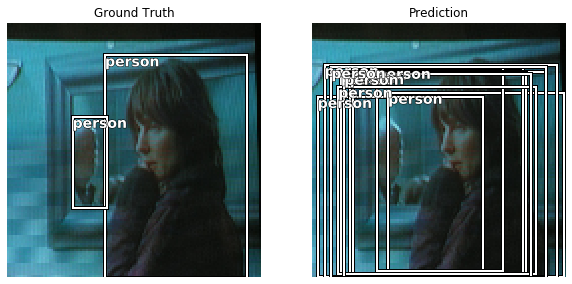

In [39]:
img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))
img_box = ImageBBox.create(128,128,yb[0][idx].cpu(),labels=yb[1][idx],classes=data.classes,scale=False)


p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors)
t_bbox = p_final_bbox.cuda().index_select(dim=0,index=idx_clas.nonzero().squeeze())
test_clas = p_f_clas.index_select(dim=0,index=idx_clas.nonzero().squeeze())
p_img_box = ImageBBox.create(128,128,t_bbox.cpu(),test_clas,classes=data.classes,scale=False)

fig,axes = plt.subplots(1,2,figsize=(10,6))
img.show(ax=axes[0],y=img_box,title='Ground Truth')
img.show(ax=axes[1],y=p_img_box,title='Prediction')

In [51]:
def show_img(idx,img_size=128,thresh=0.1):
    t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
    p_cls_test = preds[1][idx][:,1:].max(dim=1)
    idx_clas = p_cls_test[0].sigmoid() > thresh
    p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))
    img_box = ImageBBox.create(img_size,img_size,yb[0][idx].cpu(),labels=yb[1][idx],classes=data.classes,scale=False)


    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors)
    t_bbox = p_final_bbox.cuda().index_select(dim=0,index=idx_clas.nonzero().squeeze())
    test_clas = p_f_clas.index_select(dim=0,index=idx_clas.nonzero().squeeze())
    p_img_box = ImageBBox.create(img_size,img_size,t_bbox.cpu(),test_clas,classes=data.classes,scale=False)

    fig,axes = plt.subplots(1,3,figsize=(12,8))
    img.show(ax=axes[0],y=img_box,title='Ground Truth')
    img.show(ax=axes[1],y=p_img_box,title='Prediction')
    img.show(ax=axes[2],title='Original')

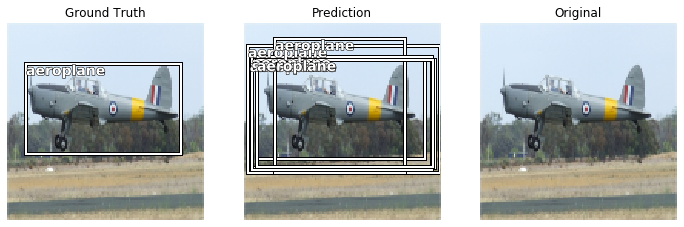

In [54]:
show_img(3,thresh=0.25)

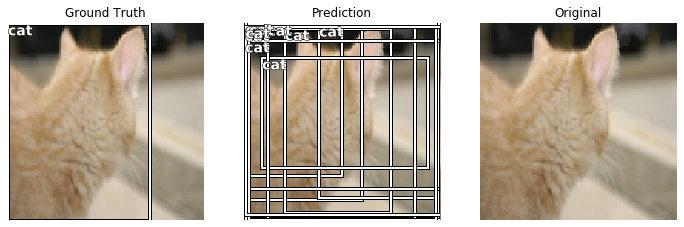

In [55]:
show_img(4,thresh=0.25)

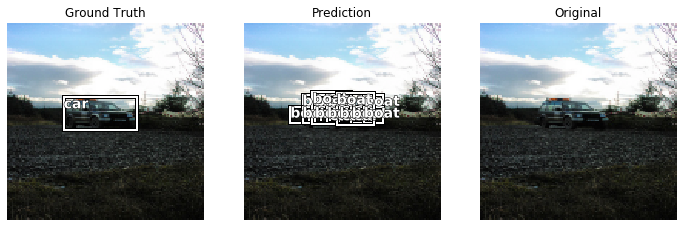

In [58]:
show_img(5,thresh=0.2)

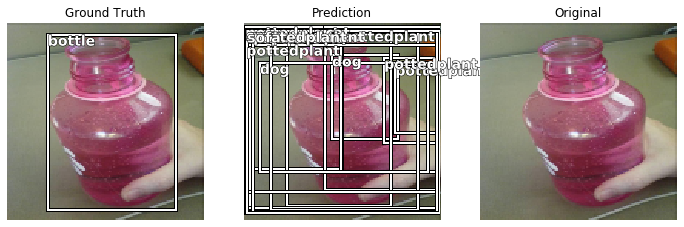

In [61]:
show_img(6,thresh=0.15)

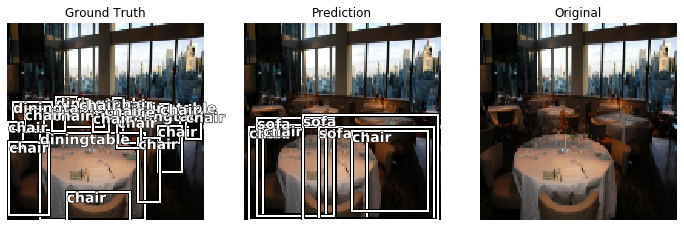

In [63]:
show_img(7,thresh=0.25)

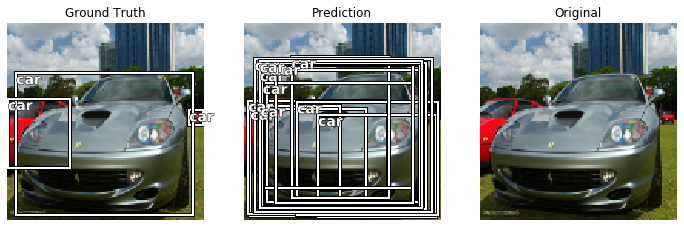

In [64]:
show_img(8,thresh=0.25)

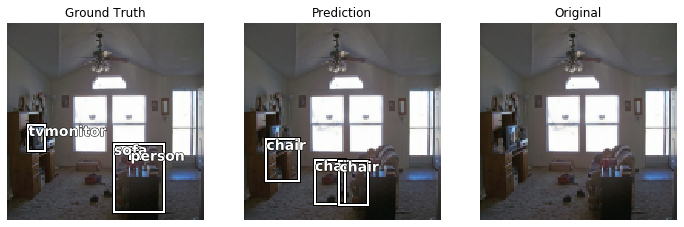

In [65]:
show_img(9,thresh=0.25)

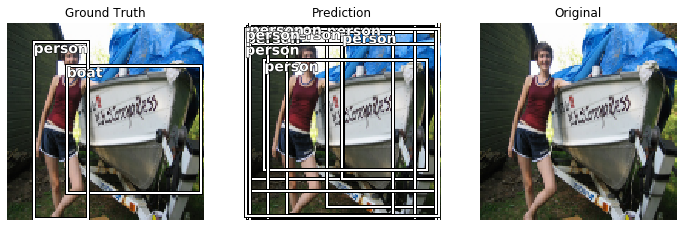

In [70]:
show_img(10,thresh=0.2)

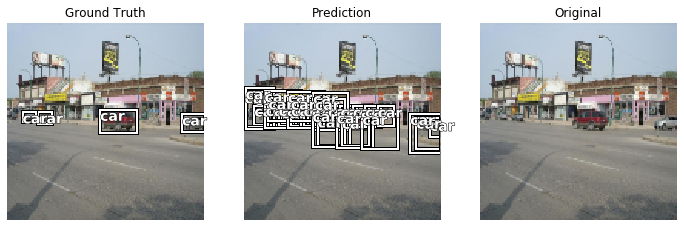

In [72]:
show_img(11,thresh=0.25)

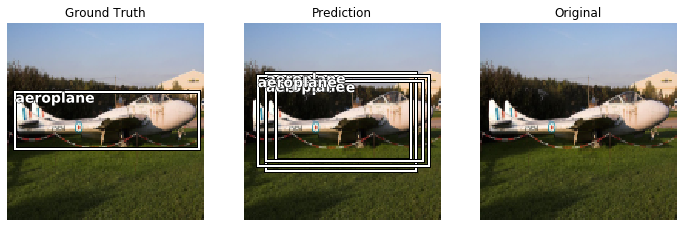

In [73]:
show_img(12,thresh=0.25)

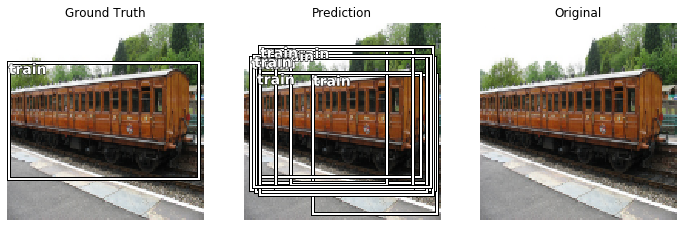

In [74]:
show_img(13,thresh=0.25)

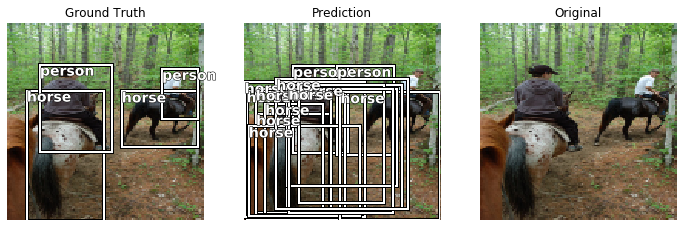

In [75]:
show_img(24,thresh=0.25)

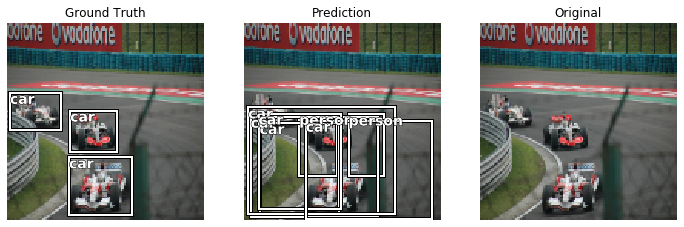

In [76]:
show_img(37,thresh=0.25)

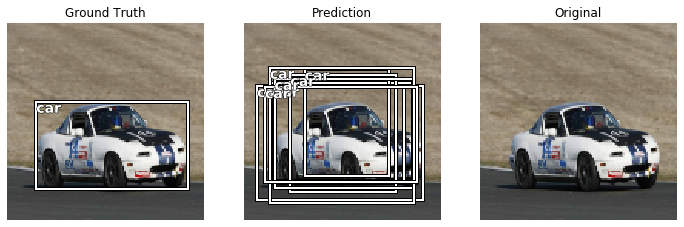

In [77]:
show_img(49,thresh=0.25)

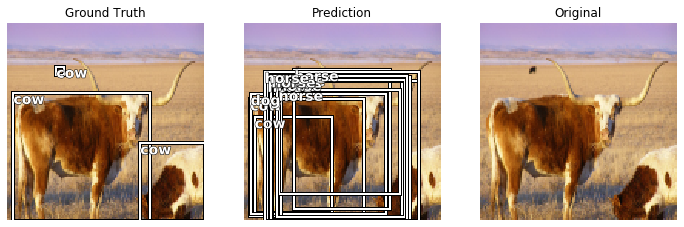

In [78]:
show_img(52,thresh=0.25)

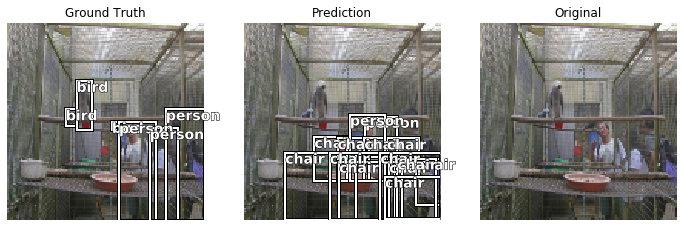

In [82]:
show_img(58,thresh=0.2)

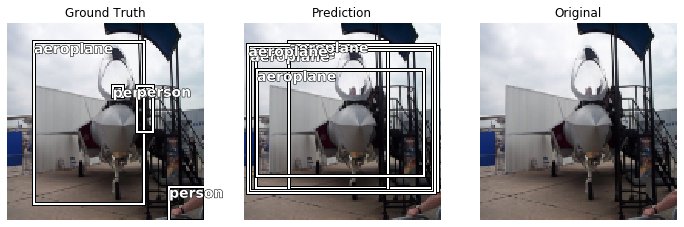

In [83]:
show_img(62,thresh=0.2)

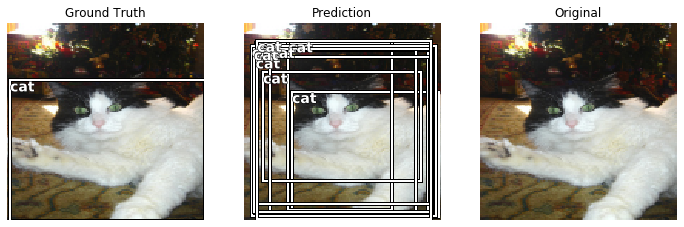

In [84]:
show_img(63,thresh=0.2)